In [1]:
# Uncomment to run the notebook in Colab
# ! pip install "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install --upgrade jax jaxlib==0.1.67+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
# check available devices
import jax

In [ ]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

# 🌡 Binning temperatures 🌡

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/03_ohlc_temperature.ipynb)

Let's again considering the air temperatures dataset.
It is sampled at a hourly resolution.
We will make "trailing" air temperature bins during each day and "reset" the bin
aggregation process at each day change.

In [1]:
import numpy as onp
import xarray as xr

In [2]:
from wax.accessors import register_wax_accessors
from wax.modules import OHLC, HasChanged

register_wax_accessors()

In [3]:
da = xr.tutorial.open_dataset("air_temperature")
da["date"] = da.time.dt.date.astype(onp.datetime64)

In [4]:
def bin_temperature(da):
    day_change = HasChanged()(da["date"])
    return OHLC()(da["air"], reset_on=day_change)


output, state = da.wax.stream().apply(
    bin_temperature, format_dims=onp.array(da.air.dims)
)
output = xr.Dataset(output._asdict())

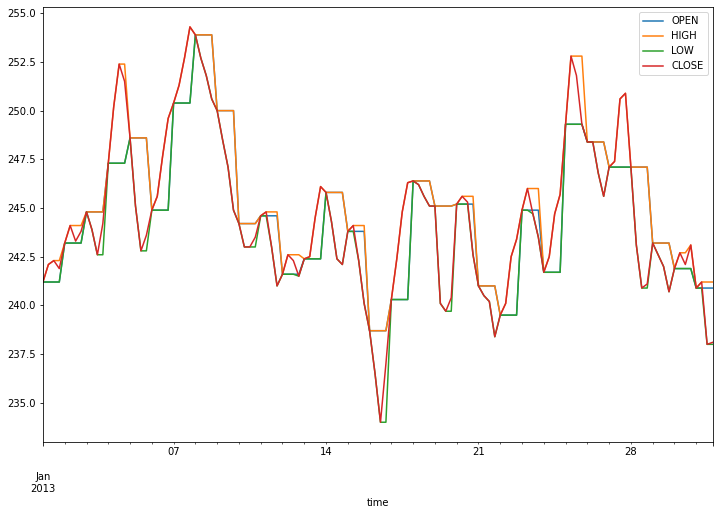

In [5]:
df = output.isel(lat=0, lon=0).drop(["lat", "lon"]).to_pandas().loc["2013-01"]
_ = df.plot(figsize=(12, 8))

## The `UpdateOnEvent` module

The `OHLC` module uses the primitive `wax.modules.UpdateOnEvent`.

Its implementation required to complete Haiku with a central function
`set_params_or_state_dict` which we have actually integrated in this WAX-ML module.

We have opened an [issue on the Haiku github](https://github.com/deepmind/dm-haiku/issues/126)
to integrate it in Haiku.